In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

# Dataset

Asaniczka. (2025). Forex Exchange Rates Since 2004 (Updated Daily) [Data set]. Kaggle.

Website: https://www.kaggle.com/datasets/asaniczka/forex-exchange-rate-since-2004-updated-daily

DOI: 10.34740/kaggle/dsv/10558683

In [4]:
# Read the "Daily Forex Rate" csv file from a google drive directory

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab/P1: Forex Regression/daily_forex_rates.csv'

df = pd.read_csv(file_path)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,currency,base_currency,currency_name,exchange_rate,date
0,ZWL,EUR,Zimbabwean Dollar,333.100155,2025-01-21
1,GHS,EUR,Ghanaian Cedi,15.476757,2025-01-21
2,HRK,EUR,Croatian Kuna,7.633949,2025-01-21
3,HNL,EUR,Honduran Lempira,26.201750,2025-01-21
4,HKD,EUR,Hong Kong Dollar,8.054134,2025-01-21
...,...,...,...,...,...
398371,JPY,EUR,Japanese Yen,133.350000,2004-09-01
398372,CAD,EUR,Canadian Dollar,1.596700,2004-08-31
398373,JPY,EUR,Japanese Yen,132.850000,2004-08-31
398374,AUD,EUR,Australian Dollar,1.729600,2004-08-31


In [6]:
# Filter for currency 'IDR'
df_idr = df[df['currency'] == 'IDR']

# Sort by date
df_idr_sorted = df_idr.sort_values(by='date')

df_idr_sorted

,currency,base_currency,currency_name,exchange_rate,date
375440,IDR,EUR,Indonesian Rupiah,15107.000000,2014-11-24
375300,IDR,EUR,Indonesian Rupiah,15218.000000,2014-11-25
375189,IDR,EUR,Indonesian Rupiah,15270.000000,2014-11-26
375078,IDR,EUR,Indonesian Rupiah,15155.000000,2014-11-27
374842,IDR,EUR,Indonesian Rupiah,15241.000000,2014-11-28
...,...,...,...,...,...
691,IDR,EUR,Indonesian Rupiah,16900.133320,2025-01-17
601,IDR,EUR,Indonesian Rupiah,16896.841442,2025-01-18
365,IDR,EUR,Indonesian Rupiah,16896.841442,2025-01-19
235,IDR,EUR,Indonesian Rupiah,16867.854127,2025-01-20


In [8]:
# Export to Google Drive as a CSV file (Only for IDR rates)
df_idr_sorted.to_csv('/content/drive/MyDrive/Colab/P1: Forex Regression/daily_forex_rates_idr.csv', index=False)

<ipython-input-35-c7edaf876053>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_idr = df_idr_sorted.resample('M').last()


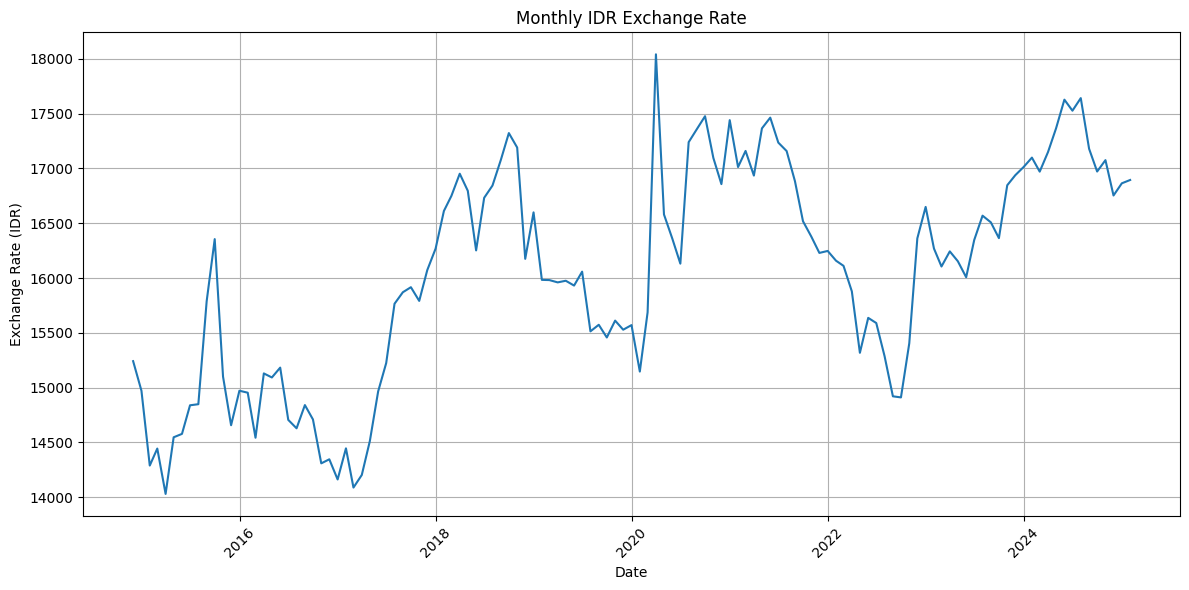

In [35]:
# For plotting, limit it to only show monthly change (for every date 1 every month). After that plot the exchange rate

# Convert 'date' column to datetime objects
df_idr_sorted.index = pd.to_datetime(df_idr_sorted['date'])

# Resample to monthly frequency, taking the last value of each month
monthly_idr = df_idr_sorted.resample('M').last()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(monthly_idr.index, monthly_idr['exchange_rate'])
plt.xlabel('Date')
plt.ylabel('Exchange Rate (IDR)')
plt.title('Monthly IDR Exchange Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Train, Valid and Test

In [21]:
# Train Valid Test Dataset here
d = df_idr_sorted
train, valid, test = np.split(d.sample(frac=1, random_state=42), [int(0.6*len(d)), int(0.8*len(d))])

# Convert to datetime, then as numeric (integers)
X_train = X_train.astype('datetime64[ns]').astype(int)
X_valid = X_valid.astype('datetime64[ns]').astype(int)
X_test = X_test.astype('datetime64[ns]').astype(int)

len(X_train), len(X_valid), len(X_test)

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(1666, 556, 556)

# Model 1: Using Simple Linear Regression

In [22]:
# Apply the linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Coefficient: ", lr_model.coef_)
print("Intercept: ", lr_model.intercept_)
print("R2 Score: ", lr_model.score(X_train, y_train))

Coefficient:  [[6.99265951e-15]]
Intercept:  [4972.47469488]
R2 Score:  0.44560739323831655


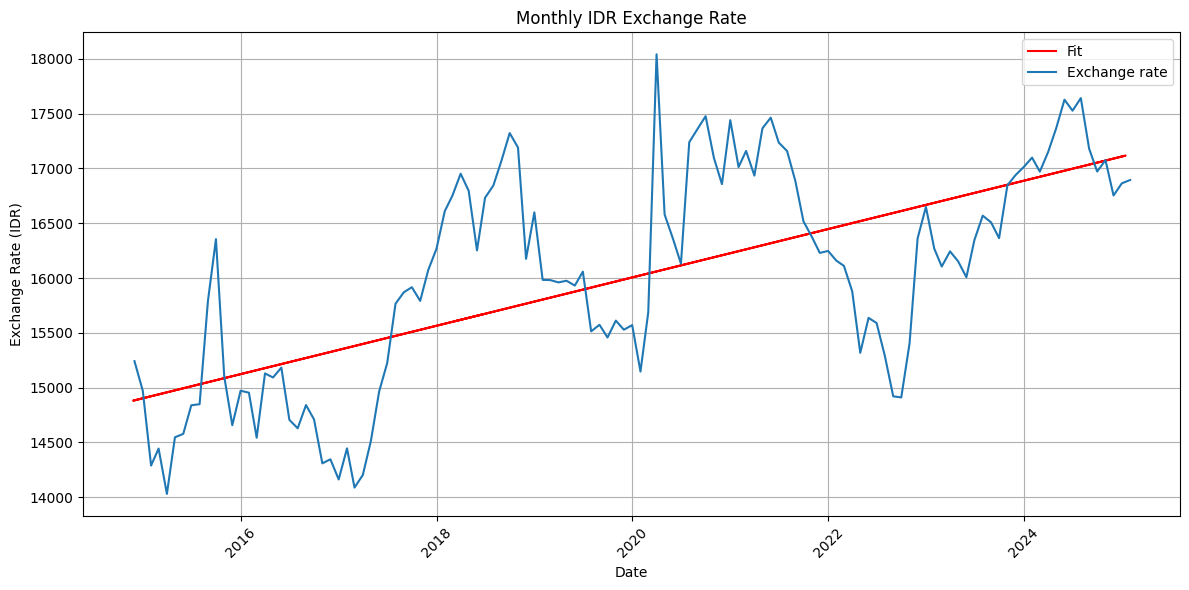

In [23]:
# Predict the model
y_pred = lr_model.predict(np.array(X_test).reshape(-1, 1))

X_test_asdate = X_test.astype('datetime64[ns]')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(X_test_asdate, y_pred, label = 'Fit', color = 'red')
plt.plot(monthly_idr.index, monthly_idr['exchange_rate'], label = 'Exchange rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (IDR)')
plt.title('Monthly IDR Exchange Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

## Trying Manual Inputs
From Jan 2025 to Jan 2028

In [14]:
# Manually input dates to predict
dates_to_predict = np.array([['2025-01-01'],['2026-01-01'],['2027-01-01'],['2028-01-01'],['2029-01-01'],['2030-01-01']])
dates_to_predict_int = dates_to_predict.astype('datetime64[ns]').astype(int)

exrate_pred = lr_model.predict(dates_to_predict_int.reshape(-1, 1))
exrate_pred = np.round(exrate_pred).astype(int)

for i in range(len(dates_to_predict)):
  print(f"{dates_to_predict[i][0]} predicted rate: {exrate_pred[i][0]}")

2025-01-01 predicted rate: 17110
2026-01-01 predicted rate: 17330
2027-01-01 predicted rate: 17551
2028-01-01 predicted rate: 17771
2029-01-01 predicted rate: 17992
2030-01-01 predicted rate: 18213


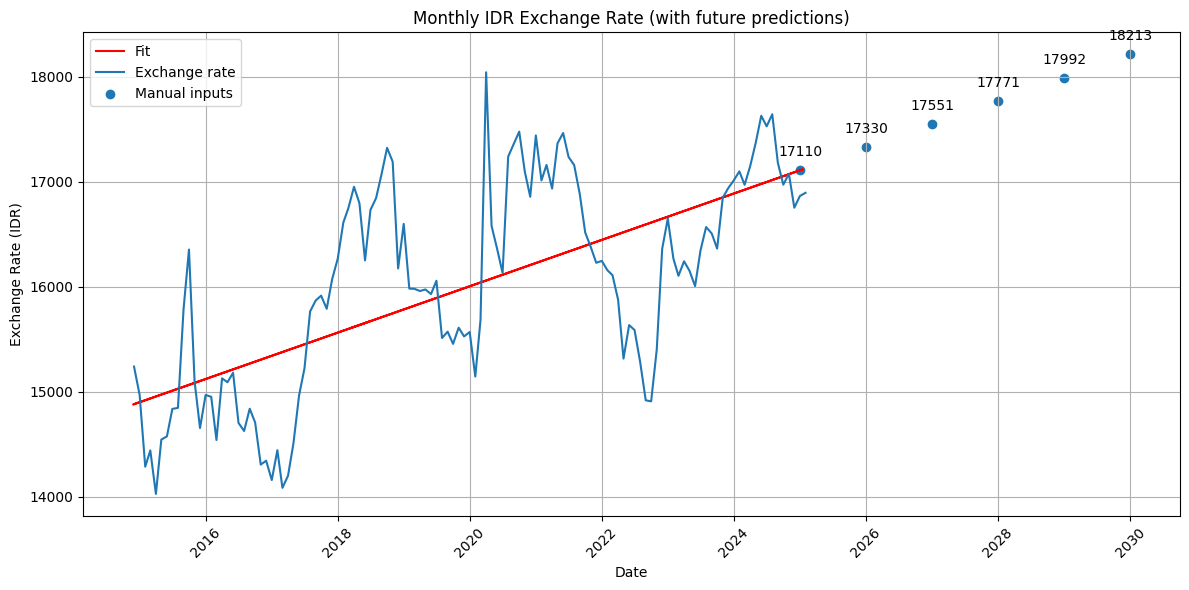

In [15]:
# Plotting the manual inputs
plt.figure(figsize=(12, 6))
plt.plot(X_test_asdate, y_pred, label = 'Fit', color = 'red')
plt.plot(monthly_idr.index, monthly_idr['exchange_rate'], label = 'Exchange rate')
plt.scatter(dates_to_predict, exrate_pred, label = 'Manual inputs')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (IDR)')
plt.title('Monthly IDR Exchange Rate (with future predictions)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

# Scatter plot with data labels
for i, txt in enumerate(exrate_pred):
    plt.annotate(txt[0], (dates_to_predict[i], exrate_pred[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

# Model 2: Using the ARIMA model to predict the trend

In [2]:
df_idr_monthly = df_idr_sorted.resample('M').last()

# Again, get the train (80%) and test (20%) dataset from a source dataset (without randomization)

train_size = int(len(df_idr_monthly) * 0.8)
train_data = df_idr_monthly[:train_size]
test_data = df_idr_monthly[train_size:]

# Separate features (X) and target variable (y)
X_train = train_data['date']
y_train = train_data['exchange_rate']
X_test = test_data['date']
y_test = test_data['exchange_rate']

for i in range(len(X_test)):
  print(X_test[i]," rate:", y_test[i])

# Convert date to numerical representation (you might need a more sophisticated method)
X_train = pd.to_datetime(X_train).astype('datetime64[ns]').astype(int)
X_test = pd.to_datetime(X_test).astype('datetime64[ns]').astype(int)

# Reshape X for models expecting 2D arrays
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

NameError: name 'df_idr_sorted' is not defined

<Figure size 640x480 with 0 Axes>

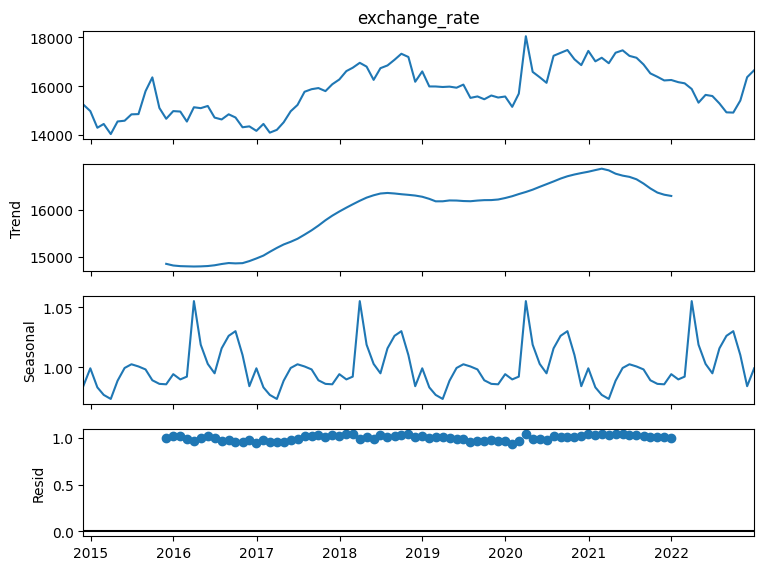

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y_train, model='multiplicative', period=24)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 6)
fig.show()

In [46]:
# !pip install pmdarima # download if not available yet
from pmdarima.arima import auto_arima

model = auto_arima(y_train, seasonal=True, m=8, suppress_warnings=True)
print(model.order)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

(0, 1, 0)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

order = (0, 1, 0)  # Example order (p, d, q)
seasonal_order = (1, 1, 0, 5)  # Example seasonal order (P, D, Q, s)

# Builde the SARIMAX Model
sarimax_model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
sarimax_results = sarimax_model.fit(disp=False)  # disp=False suppresses convergence messages

# Predict the SARIMAX model with the test data
y_sarimax_trend = sarimax_results.predict(start=1, end=len(y_train) + len(y_test))

NameError: name 'y_train' is not defined

In [89]:
y_actual_combined = pd.concat([y_train, y_test])

## Calculate MSE and R2 for the SARIMAX model
mse_sarimax = mean_squared_error(y_sarimax_trend, y_actual_combined)
r2_sarimax = r2_score(y_sarimax_trend, y_actual_combined)

print(f"SARIMAX MSE: {mse_sarimax}")
print(f"SARIMAX R2: {r2_sarimax}")

SARIMAX MSE: 850224.8142420586
SARIMAX R2: 0.3510715464448758


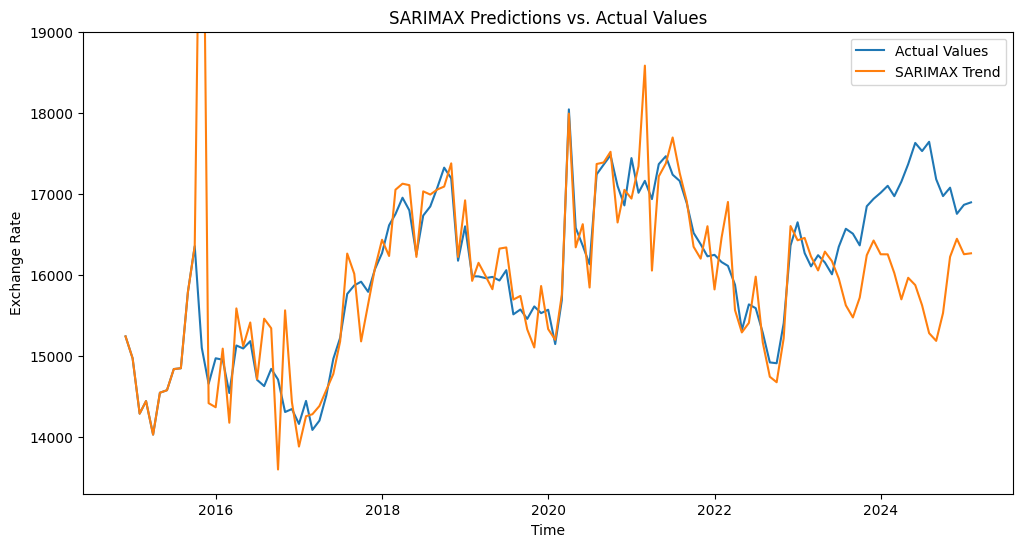

In [99]:
X_test_asdate = X_test.astype('datetime64[ns]')

# Plotting the SARIMAX trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_idr.index, monthly_idr['exchange_rate'], label = 'Actual Values')
plt.plot(monthly_idr.index, y_sarimax_trend, label='SARIMAX Trend'
plt.ylim(13300,19000)
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.title('Regressions vs. Actual Values')
plt.legend()
plt.show()